In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.4 MB/s eta 0:00:00


In [29]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Path to the folder containing images
images_folder = 'Images'

# Path to the file containing captions
captions_file = 'captions.txt'

# Read captions from the file
with open(captions_file, 'r') as file:
    captions = file.readlines()

# Iterate over the first 6 files in the 'Images' folder
for i, filename in enumerate(os.listdir(images_folder)):
    image_path = os.path.join(images_folder, filename)
    caption = captions[i].strip() if i < len(captions) else "No caption available"

    print(f"Image Path: {image_path}")
    print(f"Caption: {caption}")
    print()

    if i == 5:
        break



Image Path: Images/534655560_dc1c335b3f.jpg
Caption: image,caption

Image Path: Images/3085226474_62aba51179.jpg
Caption: 1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

Image Path: Images/3293945284_6a04e477a9.jpg
Caption: 1000268201_693b08cb0e.jpg,A girl going into a wooden building .

Image Path: Images/2279980395_989d48ae72.jpg
Caption: 1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

Image Path: Images/2151056407_c9c09b0a02.jpg
Caption: 1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .

Image Path: Images/3176278670_195eea071c.jpg
Caption: 1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .



Tokenizer for caption

In [30]:
import torch
import numpy as np
import torch.nn as nn
from transformers import GPT2Tokenizer
# Create a blank Byte-Pair Encoding tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

encoded = tokenizer.encode("A sample caption")
print(encoded)
decoded = tokenizer.decode(encoded)
print(decoded)


[32, 6291, 8305]
A sample caption


A dataset with pytorch to process the images and captions

In [31]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import random
from transformers import PreTrainedTokenizerFast


# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit most pre-trained models
    transforms.ToTensor(),
])

class Flickr8kDataset(Dataset):
    def __init__(self, annotations_file, img_dir, tokenizer, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_captions = pd.read_csv(annotations_file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.img_captions)//5

    def __getitem__(self, idx):
        file_name = self.img_captions.iloc[5*idx, 0]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        caption = random.choice(self.img_captions.iloc[5*idx : 5*(idx+1), 1].tolist())
        tokenized_caption = self.tokenizer.encode(caption)
        if self.transform:
            image = self.transform(image)
        return image, tokenized_caption

img_dir = 'Images'
annotations_file = 'captions.txt'

dataset = Flickr8kDataset(annotations_file=annotations_file, img_dir=img_dir, tokenizer=tokenizer, transform=transform)

split_point = int(0.9*len(dataset))

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split_point, len(dataset) - split_point])


create dataloaders to process batches of images and text. We implement a collate function to deal with sequences of different lenghts, and an attention_mask variable to keep track of the actual lenghts of the sequences.

In [32]:
from torch.utils.data import DataLoader, random_split

def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)

    captions = [[tokenizer.bos_token_id] + cap + [tokenizer.eos_token_id] for cap in captions]

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths), dtype=torch.long)
    # Create attention masks
    masks = torch.zeros(len(captions), max(lengths), dtype=torch.long)

    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.LongTensor(cap)
        masks[i, :end] = 1

    return images, targets, masks

train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)


a look at one of the dataloaders batch as a sanity check.

Images bach shape :torch.Size([32, 3, 224, 224])
Captions bach shape :32
tensor(11)
tensor([50256, 41044,   287, 11398, 27309,  2513,  3812,   257, 20382,  4074,
        50256,     0,     0,     0,     0,     0,     0,     0,     0])


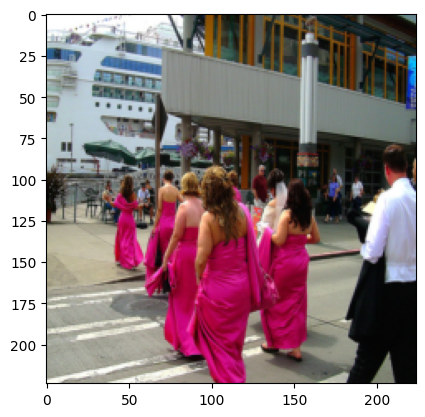

Label : <|endoftext|>Girls in pink dresses walk toward a cruise ship<|endoftext|>!!!!!!!!


In [33]:
images, captions, attention_masks = next(iter(train_dataloader))

def tensor_to_image(tensor):
    # Convert the tensor to a PIL Image
    return transforms.ToPILImage()(tensor)

print(f"Images bach shape :{images.size()}")
print(f"Captions bach shape :{len(captions)}")
img = tensor_to_image(images[0])
print(torch.where(captions[0] == 0)[0][0])
caption = captions[0]
print(caption)
label = tokenizer.decode(caption, skip_special_token=True)
plt.imshow(img)
plt.show()
print(f"Label : {label}")


initialize two pre-trained models: one for image processing (ResNet, trained on ImageNet) and one for text processing (GPT2, pretrained on a large corpus of text data).

In [34]:
from transformers import GPT2LMHeadModel
from torchvision.models import resnet50

resnet = resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-2]) # Remove avg pool and fc layer

gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet.to(device)
gpt2.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 51.2MB/s]


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

construct the whole model (ResNet + GPT2) to extract image features with ResNet, that are then combined with the input token embeddings for the GPT2-model.

In [35]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, resnet, gpt2):
        super(ImageCaptioningModel, self).__init__()
        self.resnet = resnet
        self.gpt2 = gpt2

        self.proj = nn.Linear(2048, gpt2.config.hidden_size)

    def forward(self, images, input_ids, attention_mask=None):
        img_features = self.resnet(images)
        img_features = img_features.mean([2,3])
        img_features = self.proj(img_features)

        input_embeddings = self.gpt2.transformer.wte(input_ids)
        combined_embeddings =  input_embeddings + img_features.unsqueeze(1)

        outputs = self.gpt2(inputs_embeds=combined_embeddings, attention_mask=attention_mask, labels=input_ids)
        return outputs

Training Loop

In [36]:
from transformers import AdamW

model = ImageCaptioningModel(resnet, gpt2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
print_every = 50


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    iteration_loss = 0

    for idx, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        images, input_ids, masks = batch

        optimizer.zero_grad()

        outputs = model(images, input_ids, attention_mask = masks)
        loss = outputs.loss

        loss.backward()

        optimizer.step()

        total_loss +=loss.item()
        iteration_loss += loss.item()

        if idx % print_every == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} | Iteration {idx}/{len(train_dataloader)} | "
                  f"Training Loss: {iteration_loss / print_every:.3f}")
            iteration_loss = 0

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            images, input_ids, masks = batch
            outputs = model (images, input_ids, attention_mask=masks)
            loss = outputs.loss
            val_loss += loss.item()
    val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {total_loss / len(train_dataloader):.3f} | "
          f"Validation Loss: {val_loss:.3f}\n")





Epoch 1/10 | Iteration 50/228 | Training Loss: 4.423
Epoch 1/10 | Iteration 100/228 | Training Loss: 3.119
Epoch 1/10 | Iteration 150/228 | Training Loss: 2.394
Epoch 1/10 | Iteration 200/228 | Training Loss: 2.048
Epoch 1/10 | Training Loss: 2.868 | Validation Loss: 1.713

Epoch 2/10 | Iteration 50/228 | Training Loss: 1.825
Epoch 2/10 | Iteration 100/228 | Training Loss: 1.732
Epoch 2/10 | Iteration 150/228 | Training Loss: 1.696
Epoch 2/10 | Iteration 200/228 | Training Loss: 1.630
Epoch 2/10 | Training Loss: 1.701 | Validation Loss: 1.522

Epoch 3/10 | Iteration 50/228 | Training Loss: 1.536
Epoch 3/10 | Iteration 100/228 | Training Loss: 1.595
Epoch 3/10 | Iteration 150/228 | Training Loss: 1.524
Epoch 3/10 | Iteration 200/228 | Training Loss: 1.558
Epoch 3/10 | Training Loss: 1.563 | Validation Loss: 1.492

Epoch 4/10 | Iteration 50/228 | Training Loss: 1.487
Epoch 4/10 | Iteration 100/228 | Training Loss: 1.485
Epoch 4/10 | Iteration 150/228 | Training Loss: 1.498
Epoch 4/10 | I

In [39]:
def generate_caption(image, model, tokenizer, max_length=50, temperature=1.0):

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image.unsqueeze(0), input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i>1:
                break
    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

In [40]:
tokenizer.eos_token_id

50256

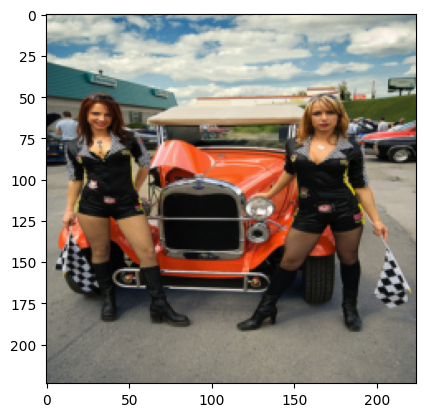

Label : A woman in a pink dress and a woman in a black dress are posing for a picture.


In [51]:
images, _, _ = next(iter(val_dataloader))
image = images[30].to(device)
img = tensor_to_image(image)

caption = generate_caption(image, model, tokenizer)

plt.imshow(img)
plt.show()
print(f"Label : {caption}")





In [47]:
assert image.unsqueeze(0).shape[0] == 1, "Only one image should be processed at a time."


Generated Caption: A boy in a blue shirt and blue shorts is jumping in a field.


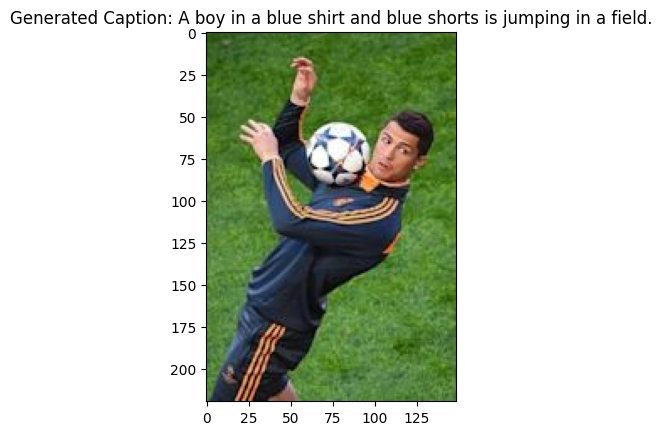

In [58]:
# Function to generate caption for a given image path
def generate_caption_for_image(model, tokenizer, image_path, max_length=50, temperature=1.0):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Generate caption
    caption = generate_caption(image.squeeze(0), model, tokenizer, max_length, temperature)

    return caption

# Example usage:
image_path = 'cris.jpeg'  # Replace with the path to your image
generated_caption = generate_caption_for_image(model, tokenizer, image_path)
print(f"Generated Caption: {generated_caption}")

# Display the image and generated caption
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Generated Caption: {generated_caption}")
plt.show()


In [59]:
# Save the entire model
torch.save(model.state_dict(), 'image_captioning_model.pth')

# # Load the model
# loaded_model = ImageCaptioningModel(resnet, gpt2)
# loaded_model.load_state_dict(torch.load('image_captioning_model.pth'))
# loaded_model.to(device)
